# Data Loading and Initial Exploration

In [2]:
import pandas as pd

# Load your data
file_path = 'stock/stocks.csv'  # Replace with your file path
stock_data = pd.read_csv(file_path)
print("Initial Data:")
print(stock_data.head())


Initial Data:
  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  


# Data Preprocessing

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting the 'Close' column for prediction
close_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Creating time steps for LSTM input
def create_dataset(data, time_step=60):
    X_data, y_data = [], []
    for i in range(len(data) - time_step - 1):
        X_data.append(data[i:(i + time_step), 0])
        y_data.append(data[i + time_step, 0])
    return np.array(X_data), np.array(y_data)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshaping data to the format required by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print("\nTraining Data Shape:")
print(X_train.shape, y_train.shape)
print("\nTesting Data Shape:")
print(X_test.shape, y_test.shape)



Training Data Shape:
(149, 60, 1) (149,)

Testing Data Shape:
(38, 60, 1) (38,)


# LSTM Model Creation

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the LSTM model
model = Sequential()

# Adding LSTM layers and Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compile the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Training

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Print training history (optional)
print(history.history)


Epoch 1/100
5/5 [==============================] - 0s 57ms/step - loss: 0.0128
Epoch 2/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0120
Epoch 3/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0123
Epoch 4/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0126
Epoch 5/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0111
Epoch 6/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0120
Epoch 7/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0128
Epoch 8/100
5/5 [==============================] - 0s 57ms/step - loss: 0.0135
Epoch 9/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0112
Epoch 10/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0112
Epoch 11/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0104
Epoch 12/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0127
Epoch 13/100
5/5 [==============================]

# Making Predictions and Visualization

2/2 [==============================] - 2s 23ms/step


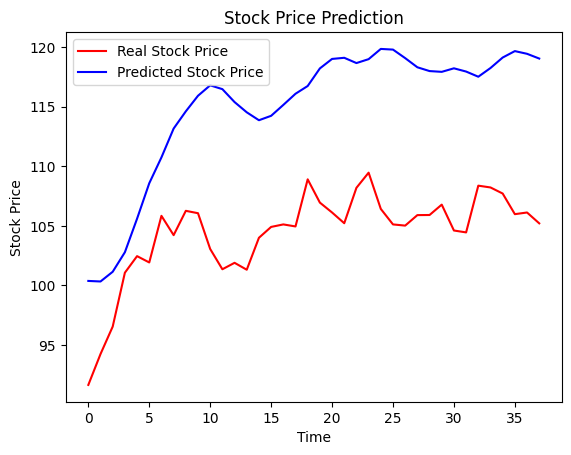

In [8]:
import matplotlib.pyplot as plt

# Making predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Inverse transform to get actual prices
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizing the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Feature Engineering: Adding More Indicators

In [9]:
import pandas as pd
import numpy as np

# Example: Calculating Moving Average
def moving_average(data, window_size=5):
    return data['Close'].rolling(window=window_size).mean()

# Example: Calculating RSI
def relative_strength_idx(data, window_size=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Load and calculate indicators
file_path = 'stock/stocks.csv'
stock_data = pd.read_csv(file_path)
stock_data['MA_5'] = moving_average(stock_data, 5)
stock_data['RSI'] = relative_strength_idx(stock_data, 14)

print("Data with Indicators:")
print(stock_data.head())


Data with Indicators:
  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume        MA_5  RSI  
0  154.414230  83322600         NaN  NaN  
1  151.688400  64120100         NaN  NaN  
2  150.639999  56007100         NaN  NaN  
3  151.009995  57450700         NaN  NaN  
4  153.850006  62199000  152.459998  NaN  


# Using a More Complex Model Architecture

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

# More complex LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru (GRU)                   (None, 60, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

# Hyperparameter Tuning

In [11]:
from tensorflow.keras.optimizers import Adam

# Hyperparameter tuning
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Adjusting epochs and batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
print("\nTraining History with New Hyperparameters:")
print(history.history)


Epoch 1/50
3/3 [==============================] - 11s 106ms/step - loss: 0.4176
Epoch 2/50
3/3 [==============================] - 0s 99ms/step - loss: 0.1252
Epoch 3/50
3/3 [==============================] - 0s 100ms/step - loss: 0.0940
Epoch 4/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0683
Epoch 5/50
3/3 [==============================] - 0s 101ms/step - loss: 0.0606
Epoch 6/50
3/3 [==============================] - 0s 103ms/step - loss: 0.0620
Epoch 7/50
3/3 [==============================] - 0s 97ms/step - loss: 0.0584
Epoch 8/50
3/3 [==============================] - 0s 106ms/step - loss: 0.0482
Epoch 9/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0446
Epoch 10/50
3/3 [==============================] - 0s 110ms/step - loss: 0.0554
Epoch 11/50
3/3 [==============================] - 0s 102ms/step - loss: 0.0434
Epoch 12/50
3/3 [==============================] - 0s 99ms/step - loss: 0.0436
Epoch 13/50
3/3 [==============================] - 0

# Incorporating Dropout for Regularization

In [12]:
# Adding Dropout for regularization
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))  # Increased dropout rate
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Correlation Heatmap

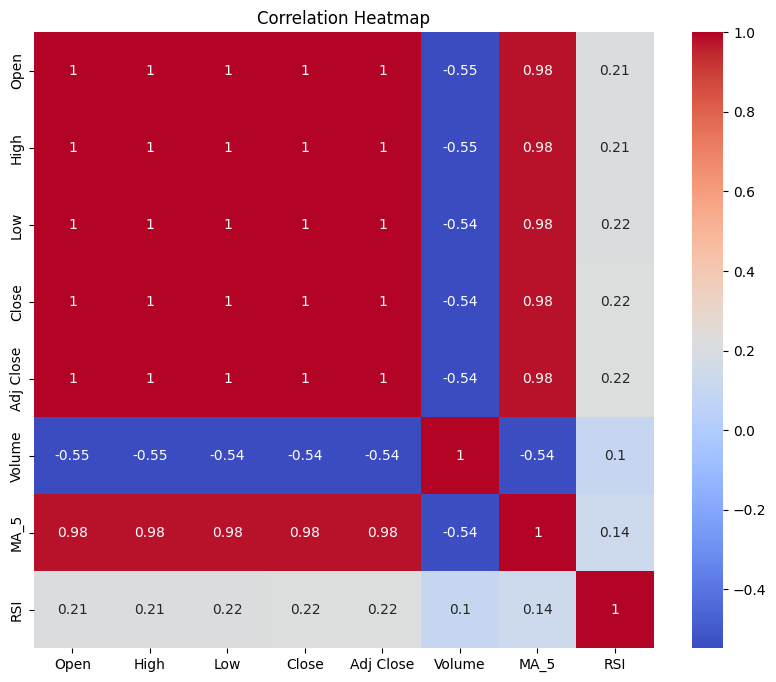

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns for correlation calculation
numeric_data = stock_data.select_dtypes(include=[np.number])

# Calculate correlation
correlation = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# Feature Importance Visualization

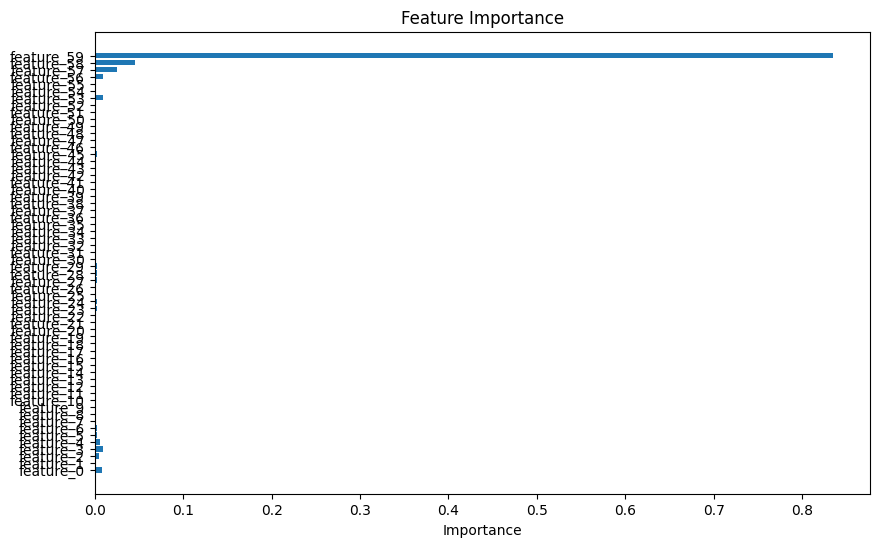

In [17]:
# Assuming X_train is your 3D data for LSTM with shape (samples, time steps, features)
# Flatten the data to 2D for RandomForestRegressor
X_train_2d = X_train.reshape((X_train.shape[0], -1))

# Now you can fit RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train_2d, y_train)

# Getting feature importance
importances = rf_model.feature_importances_
# For feature names, since the data is flattened, it's a bit more complex to name each feature
# Here we just number them for simplicity
feature_names = [f'feature_{i}' for i in range(X_train_2d.shape[1])]

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()



# Model Loss During Training

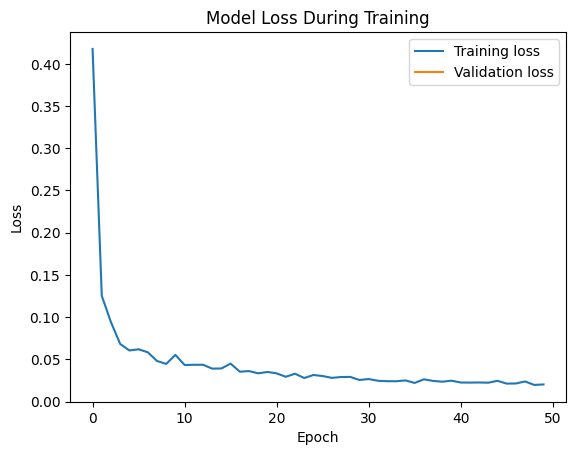

In [18]:
# Assuming 'history' contains the training history of your model
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history.get('val_loss', []), label='Validation loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


#  Time Series Decomposition

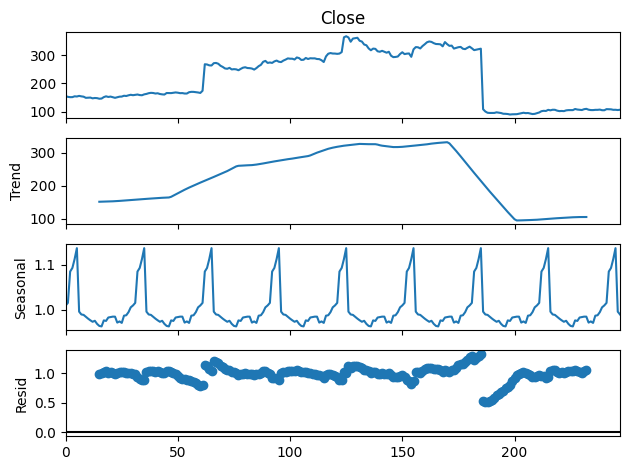

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'Close' price time series
result = seasonal_decompose(stock_data['Close'], model='multiplicative', period=30)

# Plotting the decomposition
result.plot()
plt.show()


# Cross-Validation for Time Series

In [25]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Fit your LSTM model here on X_train_cv, y_train_cv
    # ...

    # Make predictions
    predictions = model.predict(X_test_cv)
    mse = mean_squared_error(y_test_cv, predictions)
    print(f'MSE for fold: {mse}')


1/1 [==============================] - 2s 2s/step
MSE for fold: 0.47168505305653896
1/1 [==============================] - 0s 63ms/step
MSE for fold: 0.6690951554322105
1/1 [==============================] - 0s 64ms/step
MSE for fold: 0.6958811920251222
1/1 [==============================] - 0s 64ms/step
MSE for fold: 0.02166457967896839
1/1 [==============================] - 0s 69ms/step
MSE for fold: 0.0031437618882020238


# Hyperparameter Optimization

In [29]:
from tensorflow import keras
import kerastuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='stock_price_prediction')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 00m 12s]
val_loss: 0.0009412471554242074

Best val_loss So Far: 0.00013735184620600194
Total elapsed time: 00h 04m 16s


# Residual Analysis

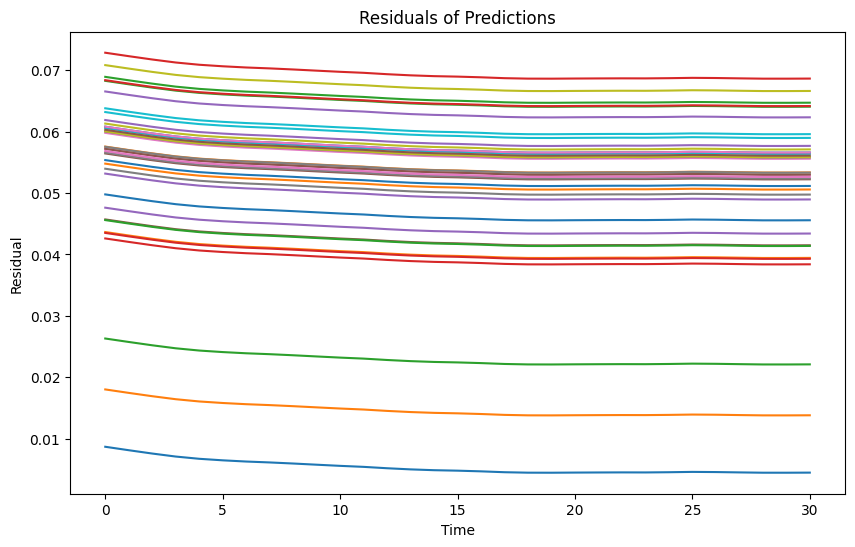

In [27]:
# Assuming you have made predictions with your model
residuals = y_test - predictions

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()


# Model Uncertainty with Monte Carlo Dropout

2/2 [==============================] - 0s 17ms/step


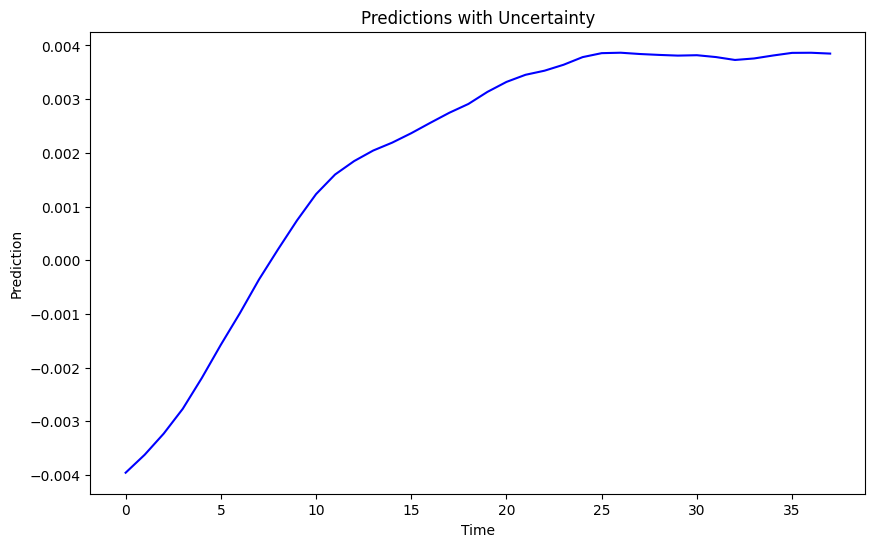

In [30]:

def predict_with_uncertainty(model, X, n_iter=100):
    predictions = np.array([model.predict(X) for _ in range(n_iter)])
    # Ensure predictions are 1-dimensional
    predictions = predictions.squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred

mean_pred, std_pred = predict_with_uncertainty(model, X_test)

# Plotting predictions with uncertainty
plt.figure(figsize=(10, 6))
plt.fill_between(range(len(mean_pred)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)
plt.plot(range(len(mean_pred)), mean_pred, color='blue')
plt.title('Predictions with Uncertainty')
plt.xlabel('Time')
plt.ylabel('Prediction')
plt.show()
